#### Note the data generated is for time independent heat equations since time dependent heat equations will require more space and more computational power and context size in case of training LLM 

In [4]:
!pip install pyvista

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.7 MB/s eta 0:00:0000:0100:01


In [5]:
# Required libraries
import numpy as np
import pyvista as pv
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
import os

In [6]:
# For creating and plotting vtk files 
def load_and_plot_vtk(filename):
    #mesh = pv.read("./working/" + filename)
    mesh = pv.read(filename)
    # Check if the file has the expected data
    print("Available Scalars:", mesh.array_names)
    
    # Plot the temperature field
    if "Temperature" in mesh.array_names:
        points = mesh.points  # (x, y, z) coordinates
        temperature = mesh['Temperature']
        print(points.shape)
        x = points[:, 0].reshape(50, 50)
        y = points[:, 1].reshape(50, 50)
        temperature = temperature.reshape(50, 50)
        plt.contourf(x, y, temperature, cmap='jet', levels=50)
        plt.colorbar()
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Temperature')
        plt.show()
    else:
        print("No 'Temperature' data found in the file.")


# Function to save data in VTK format
def save_vtk(T, X, Y, output_dir, case_name):
    """Save the temperature field to a VTK file for visualization."""
    grid = pv.StructuredGrid(X.reshape(Nx + 1, Ny + 1),
                             Y.reshape(Nx + 1, Ny + 1),
                             np.zeros_like(X).reshape(Nx + 1, Ny + 1))
    grid["Temperature"] = T
    filename = os.path.join(output_dir, f"{case_name}.vtk")
    grid.save(filename)
    print(f"Saved VTK file: {filename}")

# Directory to save the VTK files
output_dir = "./training_data"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [7]:
# Parameters and functions for solving heat equations using Finite Element Method


# Parameters
Lx, Ly = 1.0, 1.0  # Domain size (unit square)
Nx, Ny = 49, 49    # Number of elements in each direction Nx - 1, Ny - 1
T_max = 10       # Maximum time
Dt = 0.05         # Time step



# Mesh generation
x = np.linspace(0, Lx, Nx + 1)
y = np.linspace(0, Ly, Ny + 1)
X, Y = np.meshgrid(x, y)
n_nodes = (Nx + 1) * (Ny + 1)
elements = []

# Generate triangular elements (linear basis functions)
for i in range(Nx):
    for j in range(Ny):
        n0 = i * (Ny + 1) + j
        n1 = n0 + 1
        n2 = n0 + (Ny + 1)
        n3 = n2 + 1
        elements.append([n0, n1, n2])
        elements.append([n1, n3, n2])

elements = np.array(elements)

# Assembly of FEM matrices
def assemble_matrices(alpha, Nx, Ny, X, Y, elements):
    """Assemble stiffness and mass matrices for FEM."""
    n_nodes = X.size
    A = np.zeros((n_nodes, n_nodes))  # Stiffness matrix
    M = np.zeros((n_nodes, n_nodes))  # Mass matrix

    for element in elements:
        coords = np.array([[X[i], Y[i]] for i in element])
        area = 0.5 * np.abs(np.linalg.det([[1, coords[0, 0], coords[0, 1]],
                                           [1, coords[1, 0], coords[1, 1]],
                                           [1, coords[2, 0], coords[2, 1]]]))
        
        B = np.array([[coords[1, 1] - coords[2, 1], coords[2, 1] - coords[0, 1], coords[0, 1] - coords[1, 1]],
                      [coords[2, 0] - coords[1, 0], coords[0, 0] - coords[2, 0], coords[1, 0] - coords[0, 0]]]) / (2 * area)

        stiffness = (B.T @ B) * alpha * area
        mass = (np.ones((3, 3)) + np.eye(3)) * area / 12

        for i, ni in enumerate(element):
            for j, nj in enumerate(element):
                A[ni, nj] += stiffness[i, j]
                M[ni, nj] += mass[i, j]

    return csr_matrix(A), csr_matrix(M)


def solve_heat_equation_fem(A, M, T, Dt, T_max, elements, X, Y, boundary_type, force_type, alpha_type):
    """Solve the heat equation using FEM with the specified boundary, force, and alpha type."""
    n_steps = int(T_max / Dt)

    # Backward Euler scheme: (M + Dt * A) T^{n+1} = M T^n + Dt * f
    lhs = M + Dt * A

    # Loop over time steps
    for n in range(n_steps):
        t = n * Dt
        
        # Apply the force function based on the type
        f = force_function(X, Y, force_type).ravel()
        
        # Compute the right-hand side (rhs)
        rhs = M @ T + Dt * f
        
        # Solve for the next time step
        T[:] = spsolve(lhs, rhs)
        
        # Apply boundary conditions
        apply_boundary_conditions(T, Nx, Ny, boundary_type)

    return T


In [8]:
# Initial condition of temperature: Gaussian distribution
def initial_condition(x, y):
    """Define the initial temperature field as a Gaussian distribution."""
    
    return np.exp(-100 * ((x - 0.5)**2 + (y - 0.5)**2))

### Different Initial and Boundary Conditions for data generation

In [9]:
# Define boundary condition functions
def apply_boundary_conditions(T, Nx, Ny, boundary_type):
    if boundary_type == 'dirichlet':
        T[0:Ny+1] = 0          # Apply Dirichlet on the bottom row (y=0)
        T[-(Ny+1):] = 0        # Apply Dirichlet on the top row (y=1)
        T[::Ny+1] = 0          # Apply Dirichlet on the left column (x=0)
        T[Ny::Ny+1] = 0        # Apply Dirichlet on the right column (x=1)
    elif boundary_type == 'neumann':
        T = T.reshape(Nx+1, Ny+1)
        
        T[0, :] = T[1, :]
        T[-1, :] = T[-2, :]
        T[:, 0] = T[:, 1]
        T[:, -1] = T[:, -2]
        
        T = T.flatten()
        
    elif boundary_type == 'periodic':
        T[0:Ny+1] = T[-(Ny+1):]  # Apply periodic boundary conditions (y=0 to y=1)
        T[::Ny+1] = T[Ny::Ny+1]  # Periodic boundary conditions in x-direction


# Define force functions
def force_function(x, y, force_type):
    if force_type == 'case_1':
        # Sinusoidal force
        return 8 * (np.pi**2) * (np.sin(2 * np.pi * x) * np.sin(2 * np.pi * y))
    elif force_type == 'case_2':
        # Quadratic force
        return x**2 + y**2
    elif force_type == 'case_3':
        # Zero force
        return np.zeros_like(x)
    elif force_type == 'case_4':
        # Gaussian force
        return np.exp(-((x - 0.5)**2 + (y - 0.5)**2) / 0.1)
    elif force_type == 'case_5':
        # Linear force
        return x + y
    elif force_type == 'case_6':
        # Cosine-sine combination
        return np.cos(np.pi * x) * np.sin(np.pi * y)
    elif force_type == 'case_7':
        # Exponential decay
        return np.exp(-x) * np.exp(-y)
    elif force_type == 'case_8':
        # Product of x and y
        return x * y
    elif force_type == 'case_9':
        # Step function force
        return np.heaviside(x - 0.5, 1) * np.heaviside(y - 0.5, 1)
    elif force_type == 'case_10':
        # Periodic force
        return np.sin(2 * np.pi * x) * np.cos(2 * np.pi * y)
    else:
        raise ValueError("Invalid force_type. Choose from 'case_1' to 'case_10'.")



# Define alpha functions
def alpha_function(alpha_type, x, y, t):
    if alpha_type == 'constant':
        return 0.01  # Constant alpha
    elif alpha_type == 'time_dependent':
        return 0.01 * np.sin(t)  # Time-dependent alpha
    elif alpha_type == 'spatially_varying':
        return 0.01 * (x * (1 - x)) * (y * (1 - y))  # Spatially varying alpha

# Data Generation using combinations of different boundary conditions, force term (source term) and alpha

In [10]:
# Define boundary condition functions
boundary_types = ['dirichlet', 'neumann', 'periodic']
force_types = ['case_1', 'case_2', 'case_3', 'case_4','case_5','case_6','case_7','case_8','case_9','case_10',]
alpha_types = ['constant']# 'time_dependent', 'spatially_varying']

# Loop through all combinations
case_number = 1
for force in force_types:
    for boundary in boundary_types:
        for alpha in alpha_types:
            case_name = f"Case{case_number:02}"  # Generate case name for each combination
            print(f"Solving for Boundary: {boundary}, Force: {force}, Alpha: {alpha} -> {case_name}")
            
            
            # Set initial condition
            T = initial_condition(X.ravel(), Y.ravel())
            
            # Apply boundary conditions before solving
            apply_boundary_conditions(T, Nx, Ny, boundary)
            
            # Assemble the matrices (A and M) for FEM with the appropriate alpha
            A, M = assemble_matrices(alpha_function(alpha, X.ravel(), Y.ravel(), 0), Nx, Ny, X.ravel(), Y.ravel(), elements)
            
            # Solve the heat equation using FEM for each combination
            final_T = solve_heat_equation_fem(A, M, T, Dt, T_max, elements, X.ravel(), Y.ravel(), boundary, force, alpha)
            
            # Optional: Save or plot the result for each combination
            #print(f"Finished solving for {boundary}, {force}, {alpha}")

            # Save the results in VTK format
            save_vtk(final_T, X.ravel(), Y.ravel(), output_dir, case_name)
            
            # Optional: Plot or save any other data
            case_number += 1  # Increment the case number


Solving for Boundary: dirichlet, Force: case_1, Alpha: constant -> Case01
Saved VTK file: ./training_data/Case01.vtk
Solving for Boundary: neumann, Force: case_1, Alpha: constant -> Case02
Saved VTK file: ./training_data/Case02.vtk
Solving for Boundary: periodic, Force: case_1, Alpha: constant -> Case03
Saved VTK file: ./training_data/Case03.vtk
Solving for Boundary: dirichlet, Force: case_2, Alpha: constant -> Case04
Saved VTK file: ./training_data/Case04.vtk
Solving for Boundary: neumann, Force: case_2, Alpha: constant -> Case05
Saved VTK file: ./training_data/Case05.vtk
Solving for Boundary: periodic, Force: case_2, Alpha: constant -> Case06
Saved VTK file: ./training_data/Case06.vtk
Solving for Boundary: dirichlet, Force: case_3, Alpha: constant -> Case07
Saved VTK file: ./training_data/Case07.vtk
Solving for Boundary: neumann, Force: case_3, Alpha: constant -> Case08
Saved VTK file: ./training_data/Case08.vtk
Solving for Boundary: periodic, Force: case_3, Alpha: constant -> Case09

Case01.vtk
Available Scalars: ['Temperature']
(2500, 3)


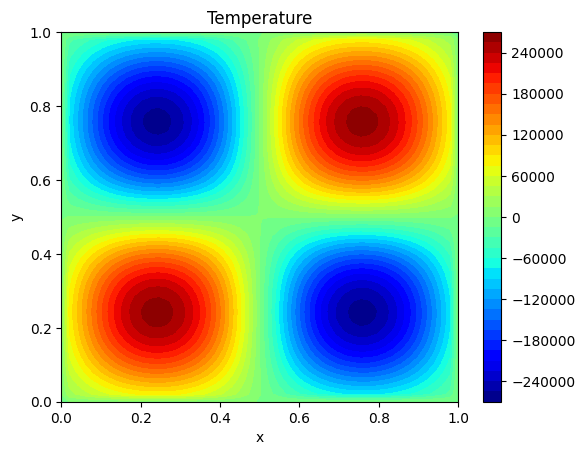

Case02.vtk
Available Scalars: ['Temperature']
(2500, 3)


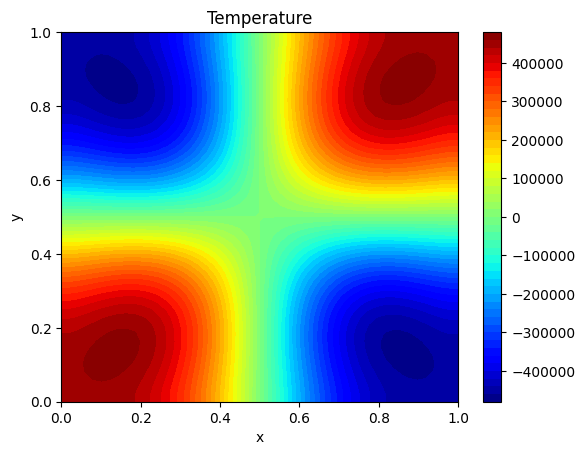

Case03.vtk
Available Scalars: ['Temperature']
(2500, 3)


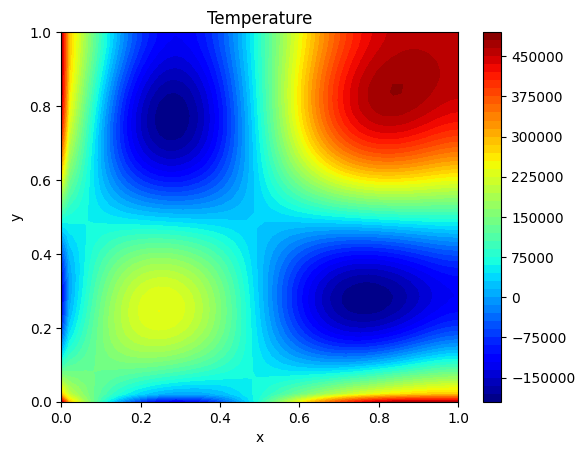

Case04.vtk
Available Scalars: ['Temperature']
(2500, 3)


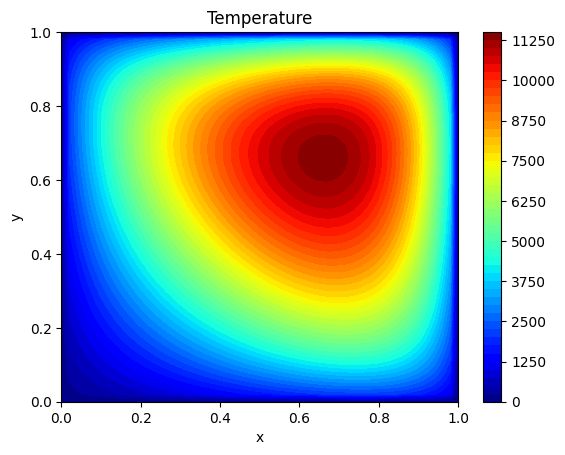

Case05.vtk
Available Scalars: ['Temperature']
(2500, 3)


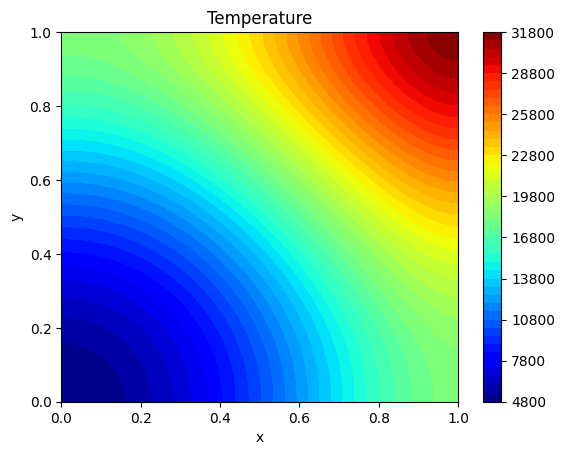

Case06.vtk
Available Scalars: ['Temperature']
(2500, 3)


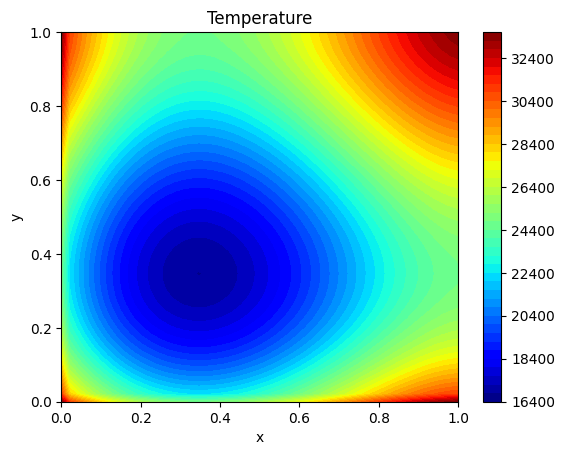

Case07.vtk
Available Scalars: ['Temperature']
(2500, 3)


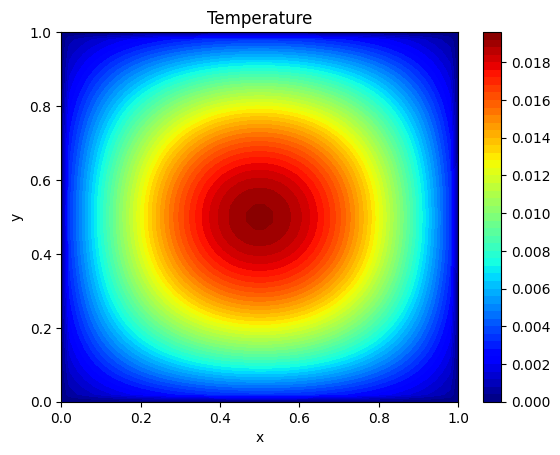

Case08.vtk
Available Scalars: ['Temperature']
(2500, 3)


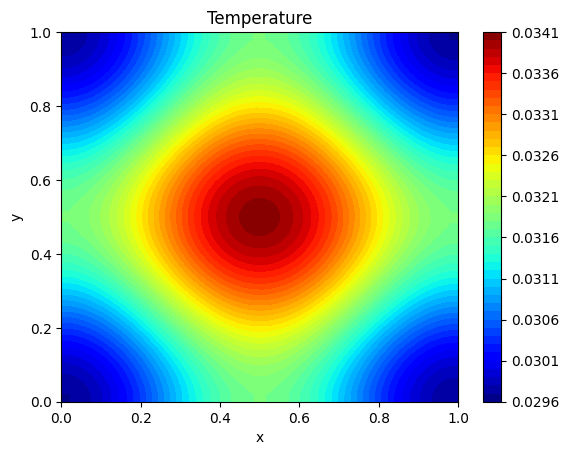

Case09.vtk
Available Scalars: ['Temperature']
(2500, 3)


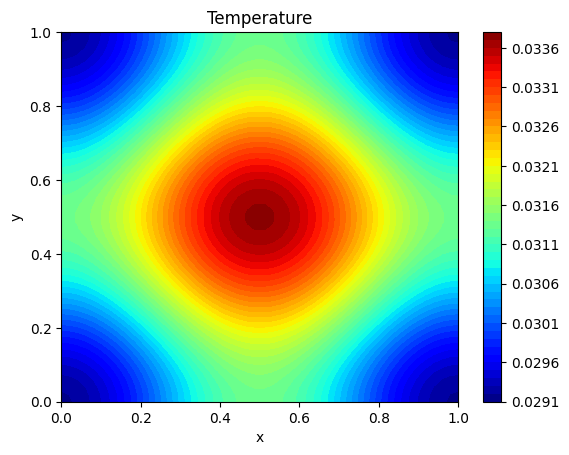

Case10.vtk
Available Scalars: ['Temperature']
(2500, 3)


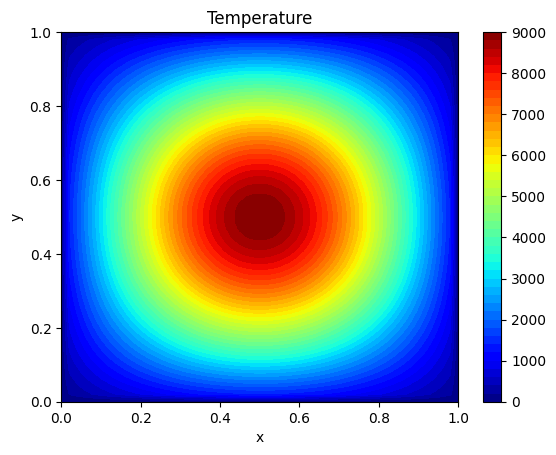

Case11.vtk
Available Scalars: ['Temperature']
(2500, 3)


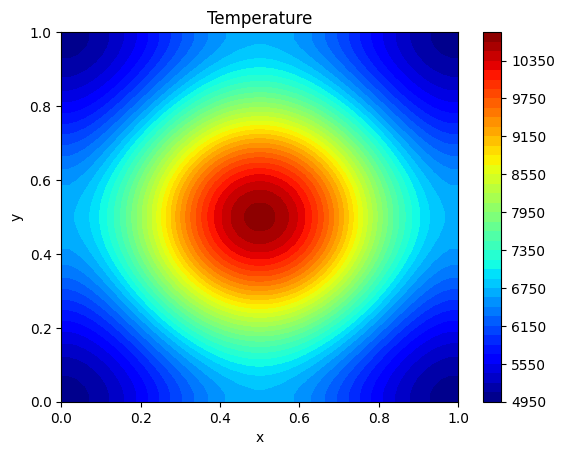

Case12.vtk
Available Scalars: ['Temperature']
(2500, 3)


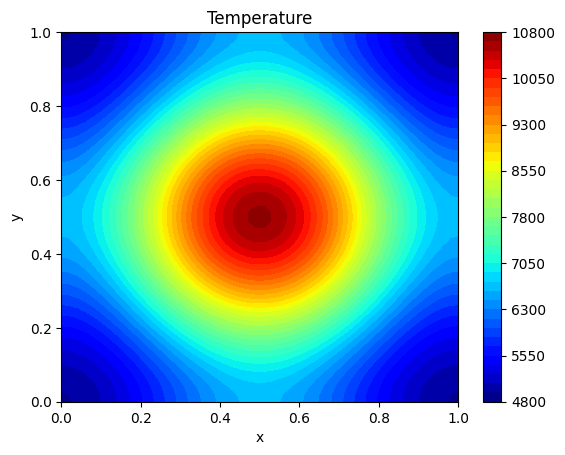

Case13.vtk
Available Scalars: ['Temperature']
(2500, 3)


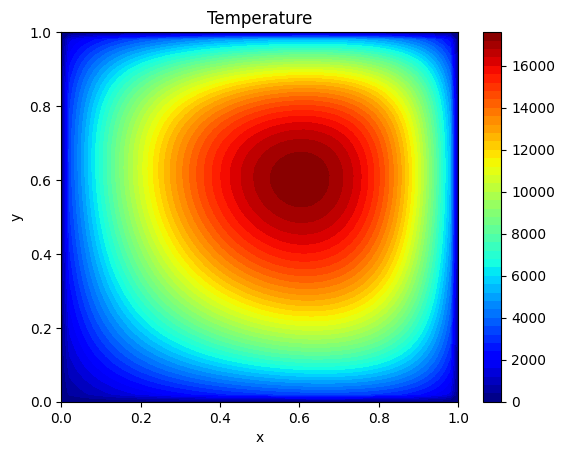

Case14.vtk
Available Scalars: ['Temperature']
(2500, 3)


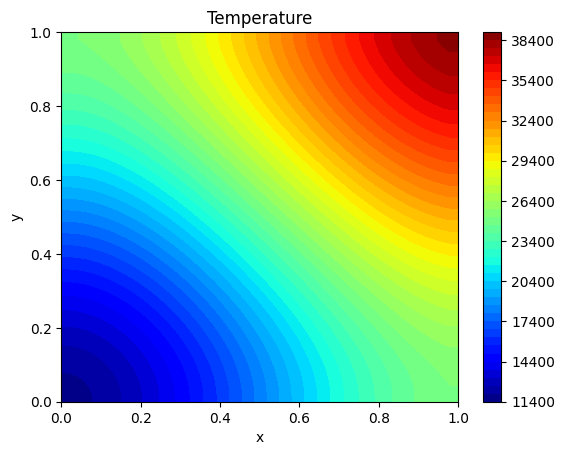

Case15.vtk
Available Scalars: ['Temperature']
(2500, 3)


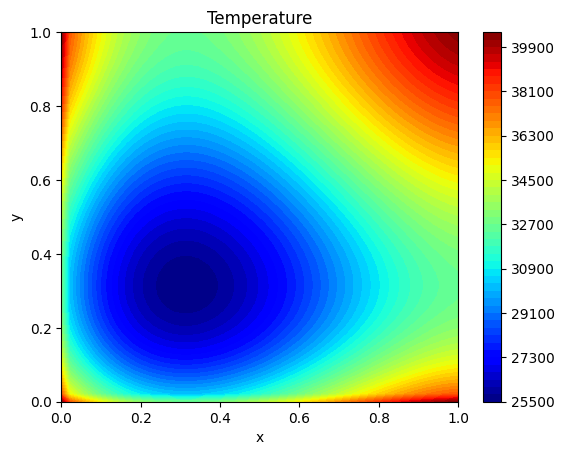

Case16.vtk
Available Scalars: ['Temperature']
(2500, 3)


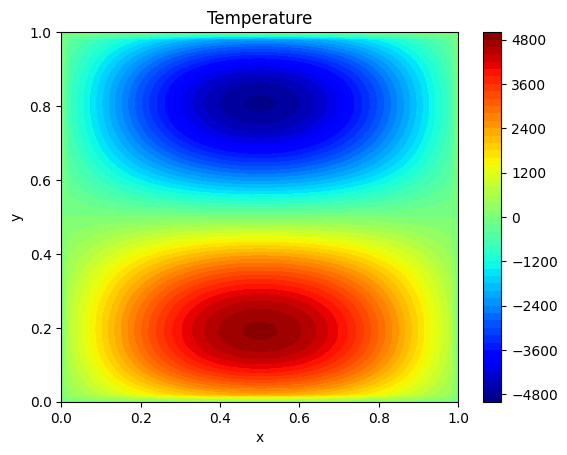

Case17.vtk
Available Scalars: ['Temperature']
(2500, 3)


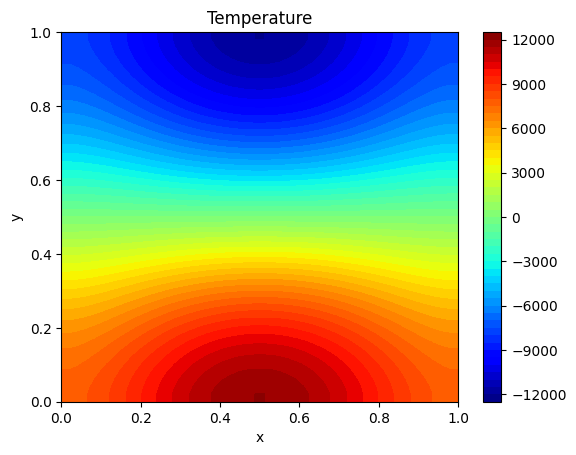

Case18.vtk
Available Scalars: ['Temperature']
(2500, 3)


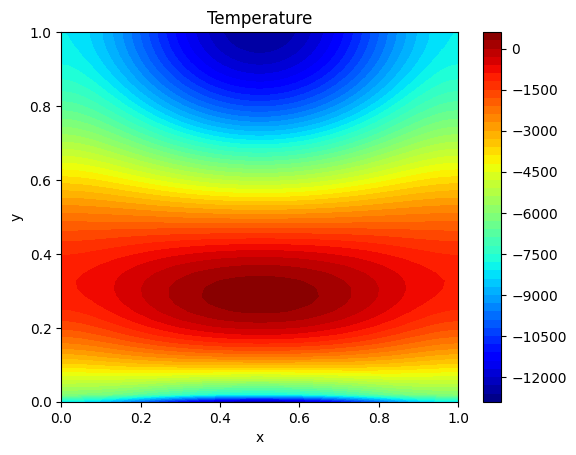

Case19.vtk
Available Scalars: ['Temperature']
(2500, 3)


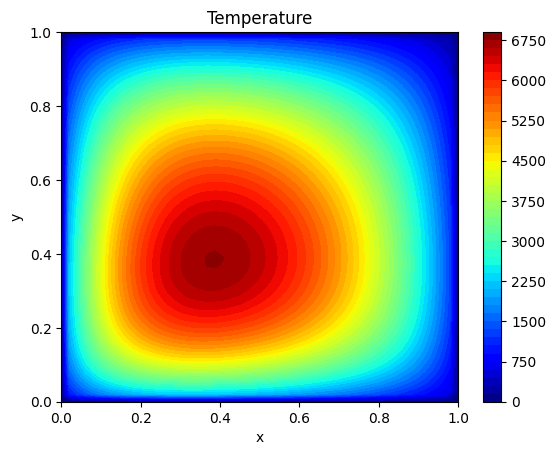

Case20.vtk
Available Scalars: ['Temperature']
(2500, 3)


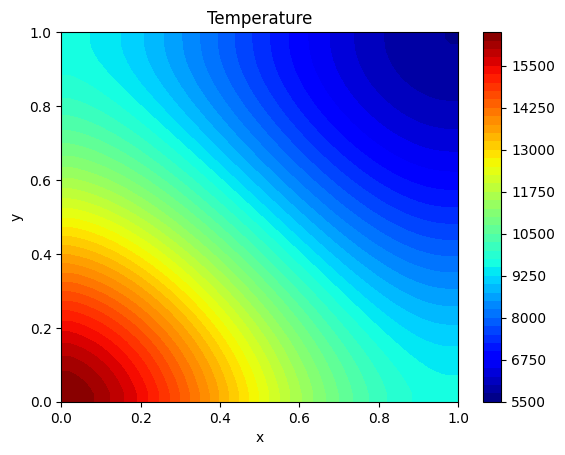

Case21.vtk
Available Scalars: ['Temperature']
(2500, 3)


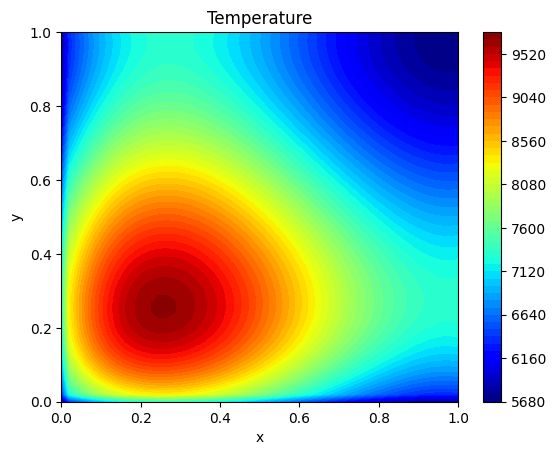

Case22.vtk
Available Scalars: ['Temperature']
(2500, 3)


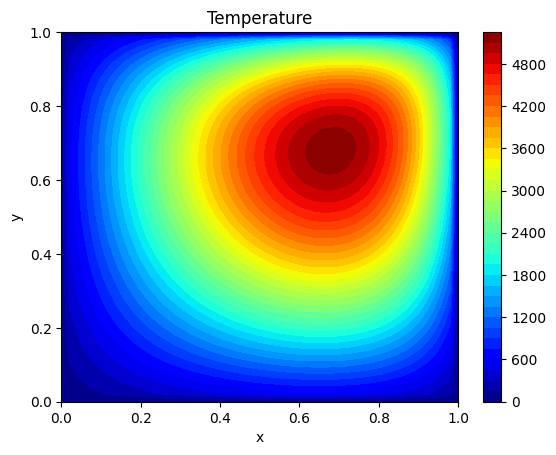

Case23.vtk
Available Scalars: ['Temperature']
(2500, 3)


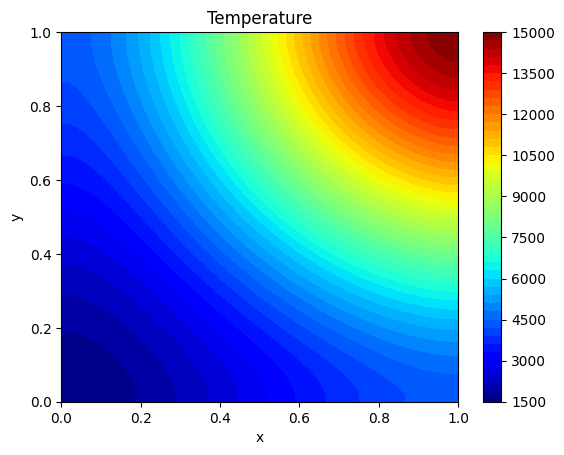

Case24.vtk
Available Scalars: ['Temperature']
(2500, 3)


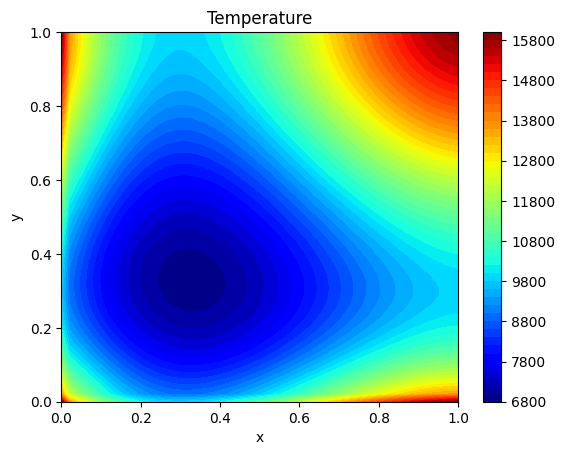

Case25.vtk
Available Scalars: ['Temperature']
(2500, 3)


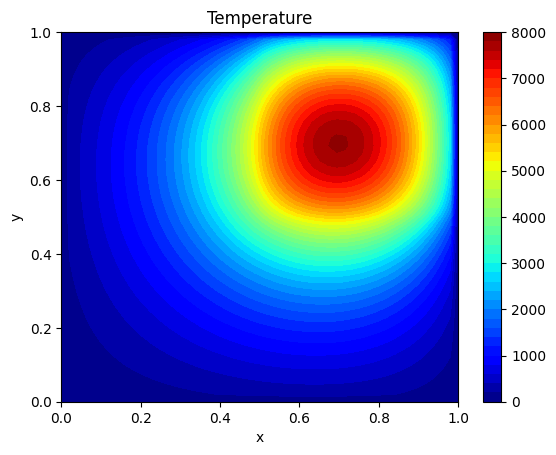

Case26.vtk
Available Scalars: ['Temperature']
(2500, 3)


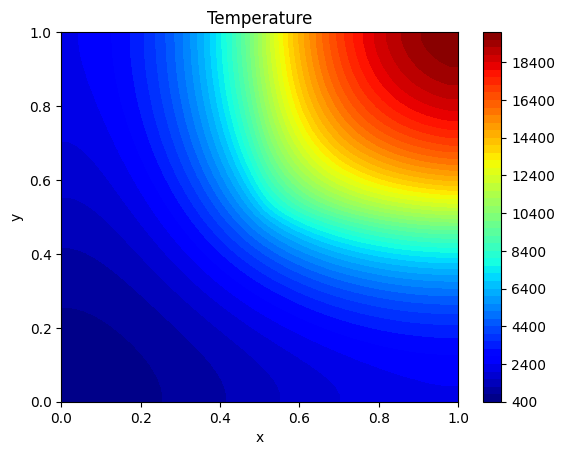

Case27.vtk
Available Scalars: ['Temperature']
(2500, 3)


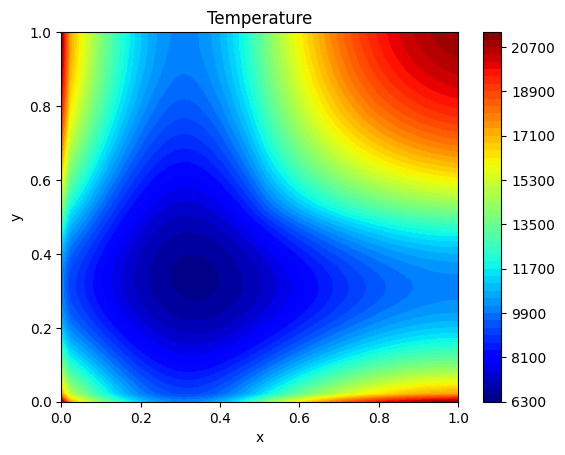

Case28.vtk
Available Scalars: ['Temperature']
(2500, 3)


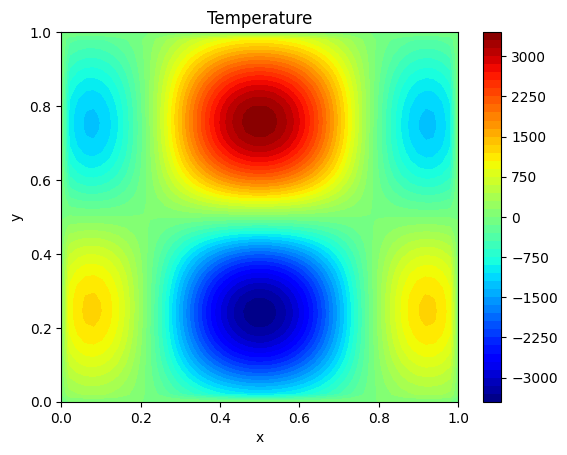

Case29.vtk
Available Scalars: ['Temperature']
(2500, 3)


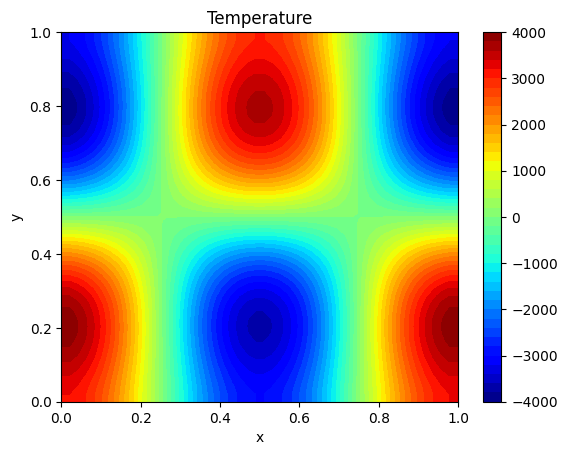

Case30.vtk
Available Scalars: ['Temperature']
(2500, 3)


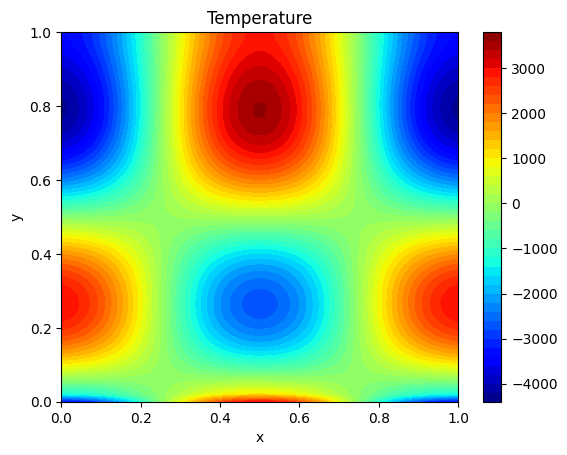

In [11]:

folder_path = '/kaggle/working/training_data'  # Replace with your folder path

# List all files in the folder
for root, dirs, files in os.walk(folder_path):
    files = sorted(files)
    for file in files:
        print(file)
        load_and_plot_vtk(os.path.join(root, file))


### Generating training data

In [12]:

folder_path = '/kaggle/working/training_data'  # Replace with your folder path
cases = []

# List all files in the folder
for root, dirs, files in os.walk(folder_path):
    files = sorted(files)
    for file in files:
        #print(file)
        cases.append(os.path.join(root, file))
        #load_and_plot_vtk(os.path.join(root, file))

In [13]:
import pyvista as pv 
import vtk
import pandas as pd


# Function to extract vtk data. This will be used later during training
def extract_vtk_data(file_path):
    
    grid = pv.read(file_path)
    
    # Extract the grid points (coordinates)
    coordinates = grid.points  # Nx3 array of (x, y, z) coordinates
    coordinates = np.array(coordinates)
    coordinates = np.round(coordinates,2)
    
    # Extract the scalar field (e.g., temperature values)
    temperatures = grid["Temperature"]  # Array of scalar values
    temperatures = np.array(temperatures)
    temperatures = np.round(temperatures, 4)

    # Combine coordinates and temperature into a single array
    data = [(point[0], point[1], temp) for point, temp in zip(coordinates, temperatures)]
    c_t = np.array((data))
    df = {"x": c_t[:,0], "y": c_t[:,1], "Temperature": c_t[:, 2]}
    df = pd.DataFrame(df)


    return df


In [14]:
# Gives the temperature at specified value
def get_temperature(df, x_value, y_value):
    # Find the row where x and y match the input values
    row = df[(df['x'] == x_value) & (df['y'] == y_value)]
    
    # Return the temperature if found, else None
    if not row.empty:
        return row['Temperature'].values[0]
    else:
        return None

In [15]:
# Necessary methods to generate prompt and response data

questions = [
        f"""Analyze the given steady-state heat equation solution, saved in the format -  \nCoordinates (x,y): Temperature at (x,y) \nAnd then tell - What is the temperature distribution at the corner (0, 0) of the unit square mesh?""",

        f"""Analyze the given steady-state heat equation solution, saved in the format -  \nCoordinates (x,y): Temperature at (x,y) \nAnd then tell - How does the temperature change with respect to the position along the x-axis at y = 0.5?""",

        f"""Analyze the given steady-state heat equation solution, saved in the format - \nCoordinates (x,y): Temperature at (x,y) \nAnd then tell at what coordinates does the maximum temperature occur.""",

        f"""Analyze the given steady-state heat equation solution, saved in the format - \nCoordinates (x,y): Temperature at (x,y) \nAnd then tell - What can you infer about the decay rate of temperature?""",
]

def solve(temp):
    answers = [
        f"The answer is {get_temperature(temp, 0.0, 0.0)}.",
        f"The answer is {temp[np.isclose(temp['y'], 0.5, atol=1e-2)]['Temperature'].mean()}.",
        f"The answer is {temp.loc[temp['Temperature'].idxmax(), 'x'],temp.loc[temp['Temperature'].idxmax(), 'y']}. ",
        f"The decay rate of temperature seems constant since the information about time is not given. "
              ]
    return answers

temp = extract_vtk_data(cases[0])


In [16]:


import re
df = pd.DataFrame()
# Use regular expression to extract the number
training_data = []
ids = 1
for case in cases:
    
    temp = extract_vtk_data(case)
    answers = solve(temp)
    for i in range(len(questions)):
        match = re.search(r'Case(\d+)',case)
        if match:
            case_number = int(match.group(1))  # Extract the number as an integer
        training_data.append([ids, case_number, questions[i], answers[i]])

        ids += 1


In [17]:
# Define column names
columns = ['Id', 'Case', 'Question', 'Answer']

# Create DataFrame
df = pd.DataFrame(training_data, columns=columns)
print(df['Question'][0])
print(df['Answer'][0])

df.to_csv('/kaggle/working/training_data/training_data.csv', index=False)  # Save without row indices

Analyze the given steady-state heat equation solution, saved in the format -  
Coordinates (x,y): Temperature at (x,y) 
And then tell - What is the temperature distribution at the corner (0, 0) of the unit square mesh?
The answer is 0.0.


In [18]:
df = pd.read_csv('/kaggle/working/training_data/training_data.csv')
df.head()

,Id,Case,Question,Answer
0,1,1,Analyze the given steady-state heat equation s...,The answer is 0.0.
1,2,1,Analyze the given steady-state heat equation s...,The answer is 549.401102.
2,3,1,Analyze the given steady-state heat equation s...,"The answer is (0.24, 0.24)."
3,4,1,Analyze the given steady-state heat equation s...,The decay rate of temperature seems constant s...
4,5,2,Analyze the given steady-state heat equation s...,The answer is 455565.7195.
